# Economic forecast based on machinery data

<i> Shun Ye CHEN, Wenbo DUAN, Louis NEL, Baoyue ZHANG </i>

## Introduction

Infrastructure development is a key driver of economic growth, and the demand for construction machinery provides valuable insights into regional economic activity. By analyzing loan data for construction equipment, we can uncover patterns that indicate economic trends across different cities in China.

Using working hours data for construction machinery across various Chinese cities, you must predict regional economic growth. 

This challenge is the usual work of economists. Understanding economic trends at a city level is crucial for policymakers, businesses, and investors. A reliable predictive model could help financial institutions optimize lending strategies, aid governments in infrastructure planning, and provide businesses with insights into emerging market opportunities.

The provided data is comes from industry partners and the China Bureau of Statistics over the timespan from January 2020 to August 2023, offering a unique opportunity to work with financial and economic indicators tied to infrastructure investments.

# Exploratory data analysis

Let's first load the data

In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

# Load the data

import problem
X_df, y = problem.get_train_data()
X_df

,Provinces,year_quarter,crane_work_hours,excavator_work_hours,roller_work_hours,construction_total_revenue
0,anhui,2020Q1,17069.045000,43322.154167,652.274167,1255.10
1,beijing,2020Q1,8721.549583,1344.029583,65.886667,1685.95
2,chongqing,2020Q1,10557.802500,13693.713333,210.141667,1643.19
3,fujian,2020Q1,15992.859583,6588.015000,143.321250,2102.66
4,guizhou,2020Q1,13567.440833,26706.963750,479.453333,670.64
...,...,...,...,...,...,...
849,tianjin,2023Q2,28584.922500,2970.941667,155.012500,1356.02
850,xinjiang,2023Q2,42428.526250,38671.359167,5793.307917,1009.83
851,xizang,2023Q2,3387.151250,5717.171250,165.725000,46.46
852,yunnan,2023Q2,29618.563333,89311.509583,2830.807917,1754.17


In [10]:
X_df["year_quarter"].unique()

array(['2020Q1', '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q3',
       '2021Q4', '2022Q2', '2022Q3', '2023Q1', '2023Q2'], dtype=object)

Notice how there is are some quarterly data missing.

In real life, people have the previous GDP data and the construction machine work hour data, and given new construction machine work hour data (which is usually given daily), they must predict the GDP (before the actual GDP data comes after the end of the quarter).

## The simple pipeline workflow

In this basic workflow, we will ignore all data about provinces or dates.

In [15]:
X_train = X_df.drop(columns=["Provinces", "year_quarter"])

Let's have a look at the data:

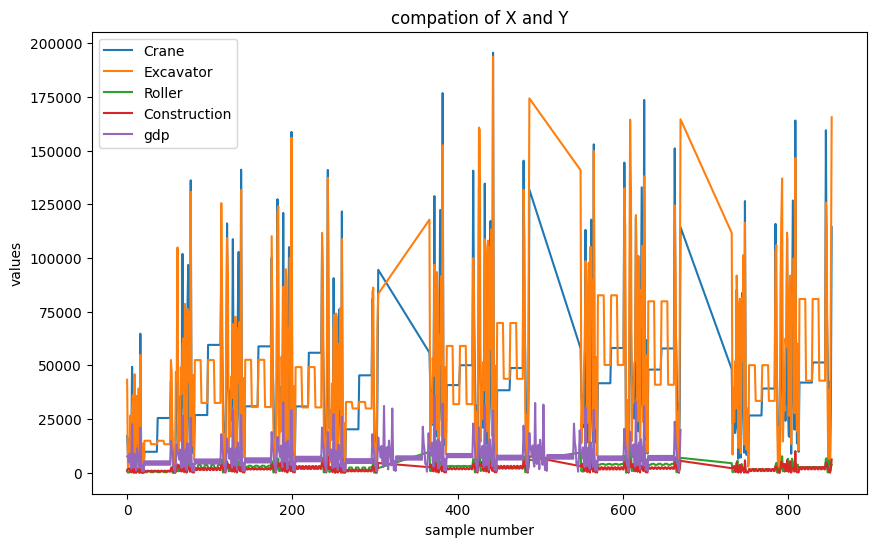

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(X_train["crane_work_hours"], label='Crane')
plt.plot(X_train["excavator_work_hours"], label='Excavator')
plt.plot(X_train["roller_work_hours"], label='Roller')
plt.plot(X_train["construction_total_revenue"], label='Construction')
plt.plot(y, label='gdp')
plt.xlabel("sample number")
plt.ylabel("values")
plt.title("compation of X and Y")
plt.legend()
plt.show()

Therefore, we need to normalize the data

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_test, y_test = problem.get_test_data()
X_test = X_test.drop(columns=["Provinces", "year_quarter"])

scalerX = StandardScaler()
scalerY = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)

y_train = scalerY.fit_transform(y.reshape(-1,1))
y_test = scalerY.transform(y_test.reshape(-1,1))

y_train = y_train.ravel() 
y_test = y_test.ravel() 

Let's test a few models:

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Define the models to compare, including MLP Regressor
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regression": DecisionTreeRegressor(random_state=42),
    "Random Forest Regression": RandomForestRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "MLP Regressor": MLPRegressor(random_state=42, max_iter=2000),
}

results = {}

# Train each model, predict on the test set, and calculate performance metrics
for name, model in models.items():
    model.fit(X_train, y)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R²": r2}

# Print out the performance comparison for each model
print("Performance comparison of models on the test set:")
for name, metrics in results.items():
    print(f"{name}: MSE = {metrics['MSE']:.4f}, R² = {metrics['R²']:.4f}")

Performance comparison of models on the test set:
Linear Regression: MSE = 87927096.0386, R² = -78208859.5773
Decision Tree Regression: MSE = 118526597.9399, R² = -105426319.1064
Random Forest Regression: MSE = 101025594.5983, R² = -89859632.7040
Support Vector Regression: MSE = 41521461.7772, R² = -36932257.2162
MLP Regressor: MSE = 74319364.6273, R² = -66105137.0996


c:\ProgramData\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


The most accurate of these models seem to be SVR... let's use this for our framework

In [ ]:
# %load submissions/starting_kit/estimator.py

from sklearn.preprocessing import StandardScaler


class Estimator:
    def __init__(self):
        self.model = SVR()
        self.scalerX = StandardScaler()
        self.scalerY = StandardScaler()
    
    def fit(self, X, y):
        X_train = self.scalerX.fit_transform(X.drop(columns=["Provinces", "year_quarter"]))
        y_train = self.scalerY.fit_transform(y.reshape(-1,1))
        self.model.fit(X_train, y_train)
        return self

    def predict(self, X):
        y_pred_scaled = self.model.predict(X.drop(columns=["Provinces", "year_quarter"]))
        return self.scalerY.inverse_transform(y_pred_scaled.reshape(-1,1))

def get_estimator():
    return Estimator()

## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).